# Projet HDDL : DeepMoji

5GMM - Emma Espinasse, Elizabeth Fu, Paul Larousse, Wilhelm Støren

Presentation on 19/01/2021

### What is Deepmoji ?

The idea behind Deepmoji is that in many cases, emojis serve as a proxy for the emotional contents of a text. Deepmoji is an available pre-trained model that can be used for different target tasks.

It was pretrained on the classification task of predicting which emoji were initially part of a text. It gives the top 5 most likely emojis for the text, as well as the probability for each suggested emoji. The study of the authors showed that this pretraining helped to have a better prediction for the target task.

### Requirements
- Python 2.7 with pip
- Theano (0.9+) or Tensorflow (1.3+)
- Keras
- scikit-learn
- h5py
- text-unidecode
- emoji

## Model architecture
The model is based on the LSTM (Long-Short Term Memory) model that has been successful at many NLP tasks.

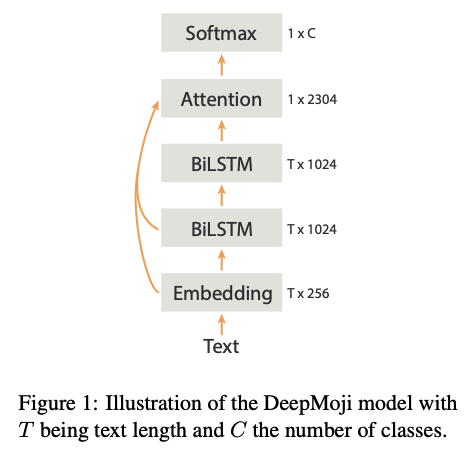

- (INPUT LAYER) embedding layer
    - 256 dimensions
    - to project each word into a vector space
    - activation function: tanh -> to constraint each embedding dimension within [-1,1]
    
- bidirectional LSTM layer
    - 1024 hidden layers (512 in each direction)
    
- bidirectional LSTM layer
    - 1024 hidden layers (512 in each direction)
    
- attention layer
    - takes all previous layers as input using skip-connections
    - lets the model decide the importance of each word for the prediction task by weighing them
    - output: representation vector $v$ (high level encoding of the entire text)

- (OUTPUT LAYER) softmax layer
    - for classification

### Transfer learning
It is the term used when a pretrained model is used for a target task.
2 common approaches:
- 'last approach': all layers of the model are frozen when fine-tuning on the target task, except the last layer.
- 'full approach': the full model is unfrozen and we take the pretrained model as an intialization for the target task

Here, new simple transfer learning approach, 'chain-thaw': sequentially unfreezes and fine-tunes a single layer at a time. By training each layer separately, the model is able to adjust the individual patterns accross the network with a reduced risk of over-fitting. Fine-tuning is done until convergence on a validation set.

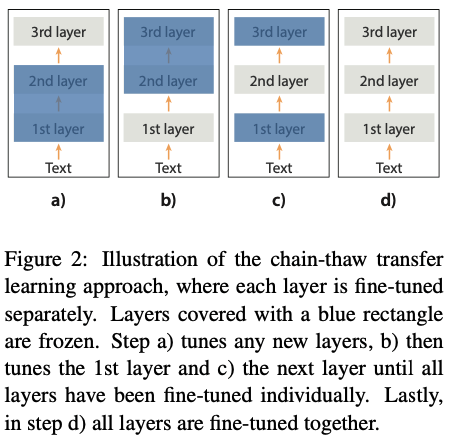

Note on step a) often, only a Softmax layer is added to tackle the target task.


### Results of the pretraining
Recall that DeepMoji was pretrained on the classification task of predicting which emoji were initially part of a text.

## Application

Here we apply the algorithm to the "Detecting Insults in Social Commentary" kaggle dataset. The challenge was to predict whether a comment posted during a public discussion is considered insulting to one of the participants. (reference : https://www.kaggle.com/c/detecting-insults-in-social-commentary/data)

The data has 2 attributes:
- date: time at which the comment was made (sometimes blank)
- comment: unicode-escaped text of the content, surrounded by double-quotes (mostly english)

Each comment has been given a label:
- 0 for a neutral comment
- 1 for an insulting comment

This is a single class (binary) classification problem.

## Limits of the Deepmoji algorithm

Some limits or issues related to the algorithm were stated by the authors themselves :
- "For some sentences it can be difficult for the model to see if the text is being ironic or not. In those cases, the most likely emojis are either very positive or very negative."
- "the model has learned about language from the raw, uncurated expressions of individuals on social media. We do not endorse in any way the emotional interpretation that the model has of any particular content."

## References

Paper https://arxiv.org/abs/1708.00524

Blog post https://medium.com/@bjarkefelbo/what-can-we-learn-from-emojis-6beb165a5ea0

Website https://deepmoji.mit.edu/

Code https://github.com/bfelbo/DeepMoji